In [1]:
# Ignore Warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Importing Libraries
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import math
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from skimage import feature
import seaborn as sns
%matplotlib inline

In [3]:
# Reading the mnist train and test in pandas dataframe
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')

In [4]:
df_train.columns

Index(['label', 'pixel0', 'pixel1', 'pixel2', 'pixel3', 'pixel4', 'pixel5',
       'pixel6', 'pixel7', 'pixel8',
       ...
       'pixel774', 'pixel775', 'pixel776', 'pixel777', 'pixel778', 'pixel779',
       'pixel780', 'pixel781', 'pixel782', 'pixel783'],
      dtype='object', length=785)

In [5]:
df_test.columns

Index(['pixel0', 'pixel1', 'pixel2', 'pixel3', 'pixel4', 'pixel5', 'pixel6',
       'pixel7', 'pixel8', 'pixel9',
       ...
       'pixel774', 'pixel775', 'pixel776', 'pixel777', 'pixel778', 'pixel779',
       'pixel780', 'pixel781', 'pixel782', 'pixel783'],
      dtype='object', length=784)

OK, So the train file has label column which is the target for us and all other 784 columns are just pixels from left to right and stacked horizontally.

As expected, test file does not have a label here.

In [6]:
# Separating train dataset into y and X

df_train_label = df_train.pop('label')
df_train_X = df_train

In [7]:
X_test = df_test

In [8]:
df_train_label.value_counts()

1    4684
7    4401
3    4351
9    4188
2    4177
6    4137
0    4132
4    4072
8    4063
5    3795
Name: label, dtype: int64

In [9]:
# As advised I am selecting only 12.5% i.e 5250 of samples from original 42000
# random_state = 101 is used for reproducibility
# stratify=y_train will keep the equal samples of all digits.

X_train, X_valid, y_train, y_valid = train_test_split(df_train_X, df_train_label, 
                                                      test_size=0.875, 
                                                      random_state=42, 
                                                      stratify=df_train_label)

In [10]:
# Check if we got equal digits in samples
y_train.value_counts()

1    586
7    550
3    544
9    524
2    522
6    517
0    516
4    509
8    508
5    474
Name: label, dtype: int64

We did not get equal samples of all the digits because stratify maintains the precentage of samples in actual dataset. Our actual dataset also has highest samples for 1 and lowest samples for 5. Rest of the digits are also in same order which is maintained in out sample dataset of 5250 samples.

This gives us an honest sample which is very likely to represent our model if built using all samples.

In [11]:
X_train.shape

(5250, 784)

In [12]:
X_train.head()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
38997,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9526,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
18035,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1337,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10289,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [13]:
# resetting the index from 0 to 5249 for easy access using iloc
X_train.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)

This is an image of 4


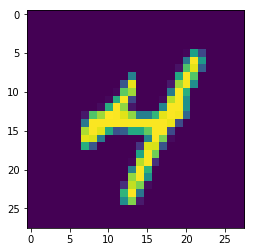

In [14]:
# Lets look at first digit image. Since we know that image size is 28 X 28
plt.imshow(X_train.iloc[75,:].values.reshape(28,28))
print("This is an image of {}".format(y_train[75]))

Although this is a 4 but it is highly slanted. On reading through various MNIST solutions I know that some preprocessing that removes this skew will enhance the dataset and hence the model.

https://en.wikipedia.org/wiki/Image_moment

Referring to the above Wikipedia link which gives information about getting orientation of an image from its moments was really helpful.

#### Deskewing the dataset

In [15]:
from numpy import sum
from scipy.ndimage import interpolation
def deskew(image):
    
    image = image.reshape(28,28)
    x, y = np.mgrid[:image.shape[0],:image.shape[1]]
    totalImage = sum(image)
    
    m0 = sum(x*image)/totalImage
    m1 = sum(y*image)/totalImage

    m00 = sum((x-m0)**2*image)/totalImage
    m11 = sum((y-m1)**2*image)/totalImage
    m01 = sum((x-m0)*(y-m1)*image)/totalImage
    mu_vec = np.array([m0,m1])
    
    cov_mat = np.array([[m00,m01],[m01,m11]])
    
    alpha = cov_mat[0,1]/cov_mat[0,0]
    affine = np.array([[1,0],[alpha,1]])
    center = np.array(image.shape)/2
    offset = mu_vec-np.dot(affine,center)
    
    return interpolation.affine_transform(image,affine,offset=offset)

In [16]:
def deskew_now(X):
    deskewed = []
    for i in range(len(X)):
        deskewed.append(deskew(X[i,:]).flatten())
    return np.array(deskewed)

In [17]:
# This took around 12 seconds to run on my PC
X_train = deskew_now(X_train.values)
X_test = deskew_now(X_test.values)
X_valid = deskew_now(X_valid.values)

In [18]:
def HOG_describe(image):
    # compute HOG for the image
    hist = feature.hog(image, orientations = 9,
        pixels_per_cell = (8, 8),
        cells_per_block = (3, 3)
        )
    return hist

In [19]:
# Saving a copy of original pixel features as we will convert these to Histogram of Oriented Gradients (HOG) features.
X_train_raw = X_train.copy()
X_test_raw = X_test.copy()
X_valid_raw = X_valid.copy()

In [20]:
# Currently the shape is
X_train.shape

(5250, 784)

In [21]:
def HOG_now(A):
    temp = []
    for i in range(A.shape[0]):
        hist = HOG_describe(A[i].reshape(28,28))
        temp.append(hist)
    return np.array(temp)

In [22]:
X_train = HOG_now(X_train)
X_test = HOG_now(X_test)
X_valid = HOG_now(X_valid)

In [23]:
X_train.shape

(5250, 81)

In [24]:
from sklearn.pipeline import Pipeline

In [25]:
''' Creating a pipeline for easy model building and adopting best practices.
I have used MinMaxScaler as it will scale the pixel value between 0 and 1.
We could have simply divided by 255 but after deskewing 
we have less 0 and more than 255 avlues also. Using polynomial kernel here'''

steps = [('scaler', MinMaxScaler()), ('SVM', SVC(kernel='poly'))]
pipeline = Pipeline(steps)

In [26]:
# Defining parameters to optimize here.
parameters = {'SVM__C':[0.001, 0.1, 1, 20], 'SVM__gamma':[10,1,0.1,0.01]}

In [27]:
# Defininf GridSearchCV object with required param & CV=5
grid = GridSearchCV(pipeline, param_grid=parameters, cv=5, verbose=10, n_jobs=-1)

In [28]:
# Actually fitting the model here
grid.fit(X_train, y_train)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    8.7s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   14.2s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   16.2s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   23.8s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:   26.4s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   34.0s
[Parallel(n_jobs=-1)]: Done  74 out of  80 | elapsed:   38.6s remaining:    3.0s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:   43.2s finished


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('SVM', SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='poly', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False))]),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'SVM__C': [0.001, 0.1, 1, 20], 'SVM__gamma': [10, 1, 0.1, 0.01]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=10)

In [29]:
scale = MinMaxScaler()

In [30]:
# We have got the best params here
grid.best_params_

{'SVM__C': 0.1, 'SVM__gamma': 10}

In [31]:
# Lets build a model using all the data and using these best_params
# Default polynomial degree of 3 is used here.

X_train = scale.fit_transform(X_train)
model = SVC(C=0.1, 
             kernel='poly', 
             gamma=10, 
             random_state=101)

In [32]:
model.fit(X_train, y_train)

SVC(C=0.1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=10, kernel='poly',
  max_iter=-1, probability=False, random_state=101, shrinking=True,
  tol=0.001, verbose=False)

In [33]:
X_valid = scale.fit_transform(X_valid)
model.score(X_valid,y_valid)

0.942530612244898

In [34]:
X_test = scale.fit_transform(X_test)
y_pred = model.predict(X_test)

In [35]:
submission = pd.read_csv('sample_submission.csv')

In [36]:
submission['Label'] = y_pred

In [37]:
submission.to_csv('submission.csv',index=False)